# CSE327 Homework 4
**Due date: 11:59 pm on Nov. 30, 2017 (Thursday)**

## Description
---
This project is an introduction to deep learning tools for computer vision. You will design and train deep convolutional networks for scene recognition using [PyTorch](http://pytorch.org).

![VGG Model](https://www.cc.gatech.edu/~hays/compvision2016/proj6/deepNetVis.png "VGG_Model")

<center>Figure 1: AlexNet / VGG-F network visualized by [mNeuron](http://vision03.csail.mit.edu/cnn_art/index.html).</center>

Remember Homework 3: Scene recognition with bag of words. You worked hard to design a bag of features representations that achieved 60% to 70% accuracy (most likely) on 15-way scene classification. You might have done the spatial pyramid extra credit and gotten up to nearly 80% accuracy. We're going to attack the same task with deep learning and get higher accuracy. Training from scratch won't work quite as well as homework 3 due to the insufficient amount of data, fine-tuning an existing network will work much better than homework 3.

In Problem 1 of the project you will train a deep convolutional network from scratch to recognize scenes. The starter code gives you a very simple network architecture which doesn't work that well and you will add jittering, normalization, regularization, and more layers to increase recognition accuracy to 50, 60, or perhaps 70%. Unfortunately, we only have 1,500 training examples so it doesn't seem possible to train a network from scratch which outperforms hand-crafted features

For Problem 2 you will instead fine-tune a pre-trained deep network to achieve about 85% accuracy on the task. We will use the pretrained AlexNet network (see Figure 1) which was not trained to recognize scenes at all. 

These two approaches represent the most common approaches to recognition problems in computer vision today -- train a deep network from scratch if you have enough data (it's not always obvious whether or not you do), and if you cannot then instead fine-tune a pre-trained network.

## Dataset
---
![Dataset Examples](https://www.cc.gatech.edu/~hays/compvision/proj4/categories.png "Example scenes from of each category in the 15 scene dataset. Figure from Lazebnik et al. 2006.")
You will using the same dataset in homework 3. The dataset contains 100 images from each category (i.e. 1500 training examples total and 1500 test cases total).  Download the dataset [here](https://drive.google.com/a/cs.stonybrook.edu/file/d/0B446EB1iI6_Qc0Q1NTRTajdUVTg/view?usp=sharing).

## Some Tutorials (PyTorch)
---
- You will be using PyTorch for deep learning toolbox (follow the [link](http://pytorch.org) for installation).
- For PyTorch beginners, please read this [tutorial](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) before doing your homework.
- Feel free to study more tutorials at http://pytorch.org/tutorials/.
- Find cool visualization here at http://playground.tensorflow.org.

## Starter Code
---
In the starter code, I provide you with a function that load data into minibatches for training and testing in PyTorch.

In [1]:
# import packages here
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import random 

import torch
import torchvision
import torchvision.transforms as transforms

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [16]:
# ==========================================
#    Load Training Data and Testing Data
# ==========================================

class_names = [name[18:] for name in glob.glob('../HW3/data/train/*')]
class_names = dict(zip(xrange(len(class_names)), class_names))
print class_names

def img_norm(img):
    return np.float32(img) / 255 # normalize img pixels to [0, 1]

def load_dataset(path, img_size, num_per_class=-1, batch_num=1, shuffle=False, augment=False, is_color=False):
    
    data = []
    labels = []
    
    if is_color:
        channel_num = 3
    else:
        channel_num = 1
        
    # read images and resizing
    for id, class_name in class_names.iteritems():
        img_path_class = glob.glob(path + class_name + '/*.jpg')
        if num_per_class > 0:
            img_path_class = img_path_class[:num_per_class]
        labels.extend([id]*len(img_path_class))
        for filename in img_path_class:
            if is_color:
                img = cv2.imread(filename)
            else:
                img = cv2.imread(filename, 0)
            
            # resize the image
            img = cv2.resize(img, img_size, cv2.INTER_LINEAR)
            
            if is_color:
                img = np.transpose(img, [2, 0, 1])
            
            # norm pixel values to [0, 1]
            data.append(img_norm(img))

    # TODO: data augmentation
    # write your code below
            
    # randomly permute (this step is important for training)
    if shuffle:
        bundle = zip(data, labels)
        random.shuffle(bundle)
        data, labels = zip(*bundle)
    
    # divide data into minibatches of TorchTensors
    if batch_num > 1:
        batch_data = []
        batch_labels = []
        for i in xrange(len(data) / batch_num):
            minibatch_d = data[i*batch_num: (i+1)*batch_num]
            minibatch_d = np.reshape(minibatch_d, (batch_num, channel_num, img_size[0], img_size[1]))
            batch_data.append(torch.from_numpy(minibatch_d))

            minibatch_l = labels[i*batch_num: (i+1)*batch_num]
            batch_labels.append(torch.LongTensor(minibatch_l))
        data, labels = batch_data, batch_labels 
    
    return zip(batch_data, batch_labels)

{0: 'Forest', 1: 'Bedroom', 2: 'Office', 3: 'Highway', 4: 'Coast', 5: 'InsideCity', 6: 'TallBuilding', 7: 'Industrial', 8: 'Street', 9: 'LivingRoom', 10: 'Suburb', 11: 'Mountain', 12: 'Kitchen', 13: 'OpenCountry', 14: 'Store'}


In [17]:
# load data into size (64, 64)

img_size = (64, 64)
batch_num = 50 # training sample number per batch 

# load training dataset
trainloader_small = load_dataset('../HW3/data/train/', img_size, batch_num=batch_num, shuffle=True, augment=True)
train_num = len(trainloader_small)
print "Finish loading %d minibatches(=%d) of training samples." % (train_num, batch_num)

# load testing dataset
testloader_small = load_dataset('../HW3/data/test/', img_size, num_per_class=100, batch_num=batch_num)
test_num = len(testloader_small)
print "Finish loading %d minibatches(=%d) of testing samples." % (test_num, batch_num)

Finish loading 30 minibatches(=50) of training samples.
Finish loading 30 minibatches(=50) of testing samples.


Below we visualize one training sample:

Suburb


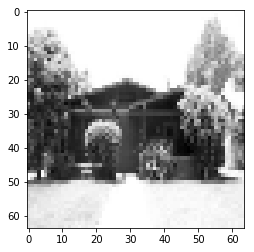

In [18]:
# show some images
def imshow(img):
    npimg = img.numpy()
    if len(npimg.shape) > 2:
        npimg = np.transpose(img, [1, 2, 0])
    plt.figure
    plt.imshow(npimg, 'gray')
    plt.show()
img, label = trainloader_small[0][0][11][0], trainloader_small[0][1][11]
print class_names[label]
imshow(img)

## Problem 1: Training a Network From Scratch
{50 points} Gone are the days of hand designed features. Now we have end-to-end learning in which a highly non-linear representation is learned for our data to maximize our objective (in this case, 15-way classification accuracy). You first task is to build a simple shallow neural network to do scene classification. Your network will be of the following architecture: Input layer takes in grayscale images are of size 64x64, followed by a convolutional layer of kernel size 9x9, stride 1 and 9 output channels, followed by ReLU and max pooling layer of kernel size 7x7 and stride 7, followed by a fully connected layer. After you do the training and testing, we can now recognize scenes with... around 25% accuracy. OK, that didn't work at all. Try to boost the accuracy by doing the following:

**Data Augmentation**: We don't have enough training data, let's augment the training data.
If you left-right flip (mirror) an image of a scene, it never changes categories. A kitchen doesn't become a forest when mirrored. This isn't true in all domains — a "d" becomes a "b" when mirrored, so you can't "jitter" digit recognition training data in the same way. But we can synthetically increase our amount of training data by left-right mirroring training images during the learning process. 

You can try more elaborate forms of jittering -- zooming in a random amount, rotating a random amount, taking a random crop, etc. Mirroring helps quite a bit on its own, though, and is easy to implement. You should see a roughly 10% increase in accuracy by adding mirroring. 

After you implement mirroring, you should notice that your training error doesn't drop as quickly. That's actually a good thing, because it means the network isn't overfitting to the 1,500 original training images as much (because it sees 3,000 training images now, although they're not as good as 3,000 truly independent samples). Because the training and test errors fall more slowly, you may need more training epochs or you may try modifying the learning rate. 

**Data Normalization**: The images aren't zero-centered. One simple trick which can help a lot is to subtract the mean from every image. It would arguably be more proper to only compute the mean from the training images (since the test/validation images should be strictly held out) but it won't make much of a difference. After doing this you should see another 10% or so increase in accuracy.

**Network Regularization**: Add a dropout layer right before the last fully connected layer. If you train your network (especially for more than the default 30 epochs) you'll see that the training error can decrease to zero while the testing error hovers at 40% to 50%. The network has learned weights which can perfectly recognize the training data, but those weights don't generalize to held out test data. The best regularization would be more training data but we don't have that. Instead we will use dropout regularization.

What does dropout regularization do? It randomly turns off network connections at training time to fight overfitting. This prevents a unit in one layer from relying too strongly on a single unit in the previous layer. Dropout regularization can be interpreted as simultaneously training many "thinned" versions of your network. At test test, all connections are restored which is analogous to taking an average prediction over all of the "thinned" networks. You can see a more complete discussion of dropout regularization in this [paper](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf).

The dropout layer has only one free parameter — the dropout rate — the proportion of connections that are randomly deleted. The default of 0.5 should be fine. Insert a dropout layer between your convolutional layers. In particular, insert it directly before your last convolutional layer. Your test accuracy should increase by another 10%. Your train accuracy should decrease much more slowly. That's to be expected — you're making life much harder for the training algorithm by cutting out connections randomly. 

If you increase the number of training epochs (and maybe decrease the learning rate) you should be able to achieve around 50% test accuracy.

**{Bonus part: 10pts}** Try one or two tricks taught in the class to increase the accuracy of your model. Such as increasing training data by random rotating training images, try different activation functions (e.g., sigmoid) and even modify the architecture of the model. Note that too many layers can do you no good due to insufficient training data.

In [ ]:
# write your code here


## Problem 2: Fine Tuning a Pre-Trained Deep Network
{50 points} Our convolutional network to this point isn't "deep". It has two layers with learned weights. Fortunately, the representations learned by deep convolutional networks is that they generalize surprisingly well to other recognition tasks. 

But how do we use an existing deep network for a new recognition task? Take, for instance,  [AlexNet](http://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks) network has 1000 units in the final layer corresponding to 1000 ImageNet categories. **Strategy A**: One could use those 1000 activation as a feature in place of a hand crafted feature such as a bag-of-features representation. You would train a classifier (typically a linear SVM) in that 1000 dimensional feature space. However, those activations are clearly very object specific and may not generalize well to new recognition tasks. It is generally better to use the activations in slightly earlier layers of the network, e.g. the 4096 activations in the last 2nd fully-connected layer. You can often get away with sub-sampling those 4096 activations considerably, e.g. taking only the first 200 activations. 

Alternatively, **Strategy B** is to *fine-tune* an existing network. In this scenario you take an existing network, replace the final layer (or more) with random weights, and train the entire network again with images and ground truth labels for your recognition task. You are effectively treating the pre-trained deep network as a better initialization than the random weights used when training from scratch. When you don't have enough training data to train a complex network from scratch (e.g. with the 15 scene database) this is an attractive option. Fine-tuning can work far better than Strategy A of taking the activations directly from an pre-trained CNN. For example, in [this paper](http://www.cc.gatech.edu/~hays/papers/deep_geo.pdf) from CVPR 2015, there wasn't enough data to train a deep network from scratch, but fine tuning led to 4 times higher accuracy than using off-the-shelf networks directly.

You are required to implement Strategy B to fine-tune a pre-trained AlexNet for this scene classification task. You should be able to achieve performance of 85% approximately. It takes roughly 35~40 minutes to train 20 epoches with AlexNet.

**{Bonus part: 15pts}** Implement Strategy A where you use the activations of the pre-trained network as features to train one-vs-all SVMs for your scene classification task. 

**Hints**:
- Many pre-trained models are available in PyTorch at [here](http://pytorch.org/docs/master/torchvision/models.html).
- For fine-tuning pretrained network using PyTorch, please read this [tutorial](http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html).
- You could also try pre-trained models other than AlexNet, VGG-16 for example, as long as there is enough memory in your computer (not mine!).
- Please resize all images to size 224x224 to use AlexNet or VGG.

In [ ]:
# write your code here


<!--Write your report here in markdown or html-->
